# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def fmt_items(lines,max_lines=0):
    max_width=max([len(line)for line in lines])
    empty =' '*max_width
    lines = [line.ljust(max_width)for line in lines]
    lines += [empty]*(max_lines - len(lines))
    return lines
    
def pp (*list):
    lines = [ str(item).split('\n') for item in list]
    max_lines=max([len(item)for  item in lines])
    lines = [fmt_items(item,max_lines=max_lines)for item in lines]
    lines_t= np.array(lines).T
    print('\n'.join([' '.join(line) for  line in lines_t]))


In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

grad_check at (0,)  num = 6.000000000039306 anal = 6.0
Gradient check passed!
grad_check at (0,)  num = 1.0000000000065512 anal = 1.0
grad_check at (1,)  num = 1.0000000000065512 anal = 1.0
Gradient check passed!
grad_check at (0, 0)  num = 1.0000000000065512 anal = 1.0
grad_check at (0, 1)  num = 1.0000000000065512 anal = 1.0
grad_check at (1, 0)  num = 1.0000000000065512 anal = 1.0
grad_check at (1, 1)  num = 1.0000000000065512 anal = 1.0
Gradient check passed!


True

In [6]:
(array_sum(np.array([5.0, 2.0]))[0]-array_sum(np.array([1.0, 2.0]))[0])/4

1.0

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [131]:
import linear_classifer 
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
print(probs)
# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
print(probs)
# assert np.isclose(probs[0], 1.0)

soft max = [2.06106005e-09 4.53978686e-05 9.99954600e-01]
[2.06106005e-09 4.53978686e-05 9.99954600e-01]
soft max = [1. 0. 0.]
[1. 0. 0.]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [8]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
    
linear_classifer.cross_entropy_loss(probs, 2)


soft max = [4.50940412e-05 6.69254912e-03 9.93262357e-01]


AttributeError: 'int' object has no attribute 'flatten'

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [ ]:
probs = linear_classifer.softmax(np.array([1, 0, 0]))
linear_classifer.cross_entropy_loss(probs, 0)

In [9]:
loss, grad= linear_classifer.softmax_with_cross_entropy(np.array([1., 0., 0.]), 0)
loss1, grad1= linear_classifer.softmax_with_cross_entropy(np.array([3, 0, 0]), 0)
loss2, grad2 = linear_classifer.softmax_with_cross_entropy(np.array([-1, 0, 0]), 0)
print((loss1-loss2)/4)
print('loss,grad = ',loss, grad)

enter of the function =  [1. 0. 0.] 0
soft max = [0.57611688 0.21194156 0.21194156]


AttributeError: 'int' object has no attribute 'flatten'

In [22]:
# TODO Implement combined function orsoftmax and cross entropy and produces gradient #-2.0491237621641485

check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([ 1,0,0], np.float))

enter of the function =  [1. 0. 0.] 1


AttributeError: 'int' object has no attribute 'flatten'

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [53]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
pp('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
pp('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
print('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
print('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

predictions = [[ 1.  2. -1.  1.]]
targets =  [[2]]
enter of the function =  [[ 1.  2. -1.  1.]] [[2]]
soft max = [[0.20603191 0.56005279 0.02788339 0.20603191]]
log =  3.5797242232074917
=N_SUMPLES= 1
loss , grand (prediction) =  3.5797242232074917 [[ 0.20603191  0.56005279 -0.97211661  0.20603191]] 
                                                                                                    
enter of the function =  [[ 1.00002  2.      -1.       1.     ]] [[2]]
soft max = [[0.20603518 0.56005049 0.02788327 0.20603106]]
log =  3.5797283438783922
=N_SUMPLES= 1
loss , grand (prediction) =  3.5797283438783922 [[ 0.20603518  0.56005049 -0.97211673  0.20603106]] 
                                                                                                    
enter of the function =  [[ 0.99998  2.      -1.       1.     ]] [[2]]
soft max = [[0.20602864 0.5600551  0.0278835  0.20603276]]
log =  3.5797201026020242
=N_SUMPLES= 1
loss , grand (prediction) =  3.5797201026020242 [[ 0.20

True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [55]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)


loss, dW = linear_classifer.linear_softmax(X, W, target_index)
pp(dW)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

enter of the function =  [[ 1. -1.]  [1 1]
                          [ 0.  3.]]      
soft max = [[0.11245721 0.01521943] 
            [0.0413707  0.83095266]]
log =  4.370364905207625
=N_SUMPLES= 2
loss , grand (prediction) =  2.1851824526038124 [[ 0.11245721 -0.48478057]  
                                                 [ 0.0413707   0.33095266]] 
loss , grand (prediction), grad by W =  2.1851824526038124 [[ 0.11245721 -0.48478057]  [[-0.11245721  0.48478057]  
                                                            [ 0.0413707   0.33095266]]  [-0.07108652  0.81573323]  
                                                                                        [ 0.15382791 -0.15382791]] 
[[-0.11245721  0.48478057] 
 [-0.07108652  0.81573323] 
 [ 0.15382791 -0.15382791]]
enter of the function =  [[ 1. -1.]  [1 1]
                          [ 0.  3.]]      
soft max = [[0.11245721 0.01521943] 
            [0.0413707  0.83095266]]
log =  4.370364905207625
=N_SUMPLES= 2
loss , grand (pr

[autoreload of linear_classifer failed: Traceback (most recent call last):
  File "c:\users\сергей\.virtualenvs\layman-s-deep-learning--lrbitjvr\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\users\сергей\.virtualenvs\layman-s-deep-learning--lrbitjvr\lib\site-packages\IPython\extensions\autoreload.py", line 434, in superreload
    module = reload(module)
  File "c:\users\сергей\.virtualenvs\layman-s-deep-learning--lrbitjvr\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "c:\users\сергей\.virtualenvs\layman-s-deep-learning--lrbitjvr\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in sour

True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [93]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

enter of L2  (3, 2) 0.01
L2 loss, grad =  0.06 [[ 0.01  0.02] 
                       [-0.01  0.01] 
                       [ 0.01  0.02]]
enter of L2  (3, 2) 0.01
L2 loss, grad =  0.06 [[ 0.01  0.02] 
                       [-0.01  0.01] 
                       [ 0.01  0.02]]
enter of L2  (3, 2) 0.01
L2 loss, grad =  0.060000200002 [[ 0.0100002  0.02     ] 
                                 [-0.01       0.01     ] 
                                 [ 0.01       0.02     ]]
enter of L2  (3, 2) 0.01
L2 loss, grad =  0.059999800002 [[ 0.0099998  0.02     ] 
                                 [-0.01       0.01     ] 
                                 [ 0.01       0.02     ]]
==GRAD_CHECK== at (0, 0)  num = 0.009999999999940612 anal = 0.01
enter of L2  (3, 2) 0.01
L2 loss, grad =  0.06000040000200001 [[ 0.01       0.0200002] 
                                      [-0.01       0.01     ] 
                                      [ 0.01       0.02     ]]
enter of L2  (3, 2) 0.01
L2 loss, grad =  0.0

True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [134]:
# TODO: Implement LinearSoftmaxClassifier.fit function 
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)
'''THERE WERE 10 EPOCHS   !!!!!
'''

enter of the function =  [[-1.00355301e-02  2.94346634e-02 -1.24129261e-02 ... -6.82652294e-03 [3 4 5 ... 4 1 9]
                            5.53978299e-06 -2.47033968e-03]                                                     
                          [ 1.09904600e-03  7.81170892e-04  1.39807856e-03 ... -3.55486628e-03                  
                           -1.16054377e-03 -4.82905733e-03]                                                     
                          [ 2.90368233e-03 -1.33169579e-03  7.49085978e-03 ... -8.90739320e-03                  
                           -3.63108012e-03 -1.19014362e-03]                                                     
                          ...                                                                                   
                          [-2.34375194e-04 -6.75812623e-03  2.93474844e-03 ... -5.56928079e-03                  
                           -8.99455695e-03  1.00103666e-02]                                     

enter of the function =  [[-0.00330276  0.01409032  0.0004134  ...  0.00978657  0.00369659 [1 1 4 ... 7 5 1]
                            0.01004468]                                                                     
                          [ 0.00457788 -0.00558165 -0.00365474 ...  0.0101945   0.00867194                  
                           -0.01806381]                                                                     
                          [-0.0011338  -0.0051951   0.00396353 ...  0.00145045 -0.00261756                  
                           -0.00229275]                                                                     
                          ...                                                                               
                          [-0.00153447  0.012333   -0.00621393 ...  0.00822976 -0.01313063                  
                           -0.00452212]                                                                     
                   

                            0.00153674]]                                                                    
soft max = [[1.12014459e-05 1.14419121e-05 1.10722428e-05 ... 1.12192307e-05
             1.11562026e-05 1.10401479e-05]                                 
            [1.10665701e-05 1.11455583e-05 1.11340307e-05 ... 1.10227398e-05
             1.11103156e-05 1.11391290e-05]                                 
            [1.10727351e-05 1.11789419e-05 1.10752897e-05 ... 1.11322231e-05
             1.10340537e-05 1.10587248e-05]                                 
            ...                                                             
            [1.12197279e-05 1.11860260e-05 1.10889989e-05 ... 1.10995854e-05
             1.11975829e-05 1.10330416e-05]                                 
            [1.11115177e-05 1.09547150e-05 1.10789241e-05 ... 1.10533924e-05
             1.11336791e-05 1.11631621e-05]                                 
            [1.10395786e-05 1.09390162e-05 1

soft max = [[1.10968693e-05 1.09917318e-05 1.10218148e-05 ... 1.10549673e-05
             1.10312585e-05 1.09742581e-05]                                 
            [1.10435864e-05 1.10023427e-05 1.11652676e-05 ... 1.10072438e-05
             1.09568851e-05 1.11286842e-05]                                 
            [1.09548288e-05 1.14971357e-05 1.09256501e-05 ... 1.12309197e-05
             1.10133357e-05 1.11570725e-05]                                 
            ...                                                             
            [1.10447275e-05 1.11032419e-05 1.09126554e-05 ... 1.12217458e-05
             1.08938277e-05 1.09782634e-05]                                 
            [1.10646805e-05 1.10950647e-05 1.11201956e-05 ... 1.10692949e-05
             1.11290664e-05 1.11564029e-05]                                 
            [1.10672709e-05 1.09346663e-05 1.11847845e-05 ... 1.10084781e-05
             1.09940129e-05 1.11719110e-05]]                                

                            0.00178031]]                                                                    
soft max = [[1.08803892e-05 1.11108584e-05 1.11533073e-05 ... 1.10054405e-05
             1.09667537e-05 1.10819560e-05]                                 
            [1.12358523e-05 1.12296722e-05 1.10235048e-05 ... 1.12947492e-05
             1.12586667e-05 1.10032734e-05]                                 
            [1.11337698e-05 1.11115294e-05 1.11727207e-05 ... 1.10282961e-05
             1.12093642e-05 1.11777726e-05]                                 
            ...                                                             
            [1.10996161e-05 1.10905215e-05 1.10753062e-05 ... 1.11720521e-05
             1.10864580e-05 1.11028991e-05]                                 
            [1.12573247e-05 1.12754768e-05 1.10379648e-05 ... 1.10517187e-05
             1.10943625e-05 1.11389709e-05]                                 
            [1.11712818e-05 1.11169248e-05 1

'THERE WERE 10 EPOCHS   !!!!!\n'

[11.438259239499832, 11.438913775478367, 11.439581294729212, 11.440262058362324, 11.440956332804436, 11.441664389908976, 11.442386507068308, 11.4431229673284, 11.443874059505866, 11.444640078307525]


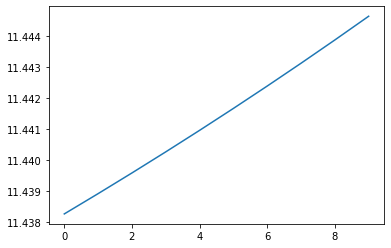

In [121]:
# let's look at the loss history!
print(loss_history)
plt.plot(loss_history)

In [172]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.105
enter of the function =  [[ 0.00036065  0.00741622  0.00767822 ... -0.01749723  0.01330699 [8 9 1 ... 2 3 5]
                            0.00738546]                                                                     
                          [-0.04605811  0.00709856 -0.05604387 ...  0.10508821 -0.06422001                  
                           -0.08528427]                                                                     
                          [-0.00661998 -0.01521634 -0.01648008 ... -0.00855813 -0.00954867                  
                            0.00645837]                                                                     
                          ...                                                                               
                          [ 0.05272406 -0.03365243  0.0381907  ... -0.06392462  0.05840768                  
                            0.03319325]                                                                     
  

                            0.02633483]]                                                                    
soft max = [[1.14444756e-05 1.07753852e-05 1.12910853e-05 ... 1.05204932e-05
             1.16703169e-05 1.15108854e-05]                                 
            [1.11287912e-05 1.09319702e-05 1.10001720e-05 ... 1.07526250e-05
             1.10823420e-05 1.12882169e-05]                                 
            [1.03940190e-05 1.09363347e-05 1.06227889e-05 ... 1.19171405e-05
             1.04929310e-05 1.07943664e-05]                                 
            ...                                                             
            [1.16405974e-05 1.07660427e-05 1.13610799e-05 ... 1.04793570e-05
             1.17023290e-05 1.16924340e-05]                                 
            [1.11128505e-05 1.09026226e-05 1.06606783e-05 ... 1.22447049e-05
             1.06733651e-05 1.06468847e-05]                                 
            [1.14511267e-05 1.09720635e-05 1

                           -5.74315501e-02 -7.65730415e-02]]                                                    
soft max = [[1.13284403e-05 1.08605823e-05 1.11472199e-05 ... 1.04971023e-05
             1.13411419e-05 1.13735078e-05]                                 
            [1.13006763e-05 1.07225309e-05 1.14711187e-05 ... 1.07225529e-05
             1.11857888e-05 1.13148642e-05]                                 
            [1.12603378e-05 1.12287997e-05 1.10503941e-05 ... 1.10362515e-05
             1.13264163e-05 1.11327316e-05]                                 
            ...                                                             
            [1.11093398e-05 1.05953207e-05 1.11307412e-05 ... 1.06473775e-05
             1.14889917e-05 1.15824379e-05]                                 
            [1.04004100e-05 1.10228018e-05 1.02825558e-05 ... 1.15486896e-05
             1.05994421e-05 1.03443079e-05]                                 
            [1.06215175e-05 1.10767793e-

                           -0.03627693]]                                                                    
soft max = [[1.13767671e-05 1.05175212e-05 1.16459962e-05 ... 1.04005446e-05
             1.19970800e-05 1.19376685e-05]                                 
            [1.15842908e-05 1.10771535e-05 1.12404403e-05 ... 1.10672334e-05
             1.18969921e-05 1.15580495e-05]                                 
            [1.08857023e-05 1.10295106e-05 1.05347795e-05 ... 1.23280446e-05
             1.07768047e-05 9.99328107e-06]                                 
            ...                                                             
            [1.11900660e-05 1.09852457e-05 1.08978801e-05 ... 1.07340744e-05
             1.11311389e-05 1.15774880e-05]                                 
            [1.06852954e-05 1.08528952e-05 1.00458298e-05 ... 1.24858562e-05
             1.02362005e-05 9.92341606e-06]                                 
            [1.08731746e-05 1.09255157e-05 1

enter of the function =  [[-0.03144864 -0.00722059 -0.00640492 ...  0.01928402 -0.03556456 [2 4 0 ... 4 7 4]
                           -0.0153312 ]                                                                     
                          [ 0.01599411  0.03374432  0.01842594 ... -0.00459448  0.01243747                  
                            0.00635316]                                                                     
                          [-0.02513055 -0.00070922 -0.02776679 ...  0.05322319 -0.02777818                  
                           -0.03261684]                                                                     
                          ...                                                                               
                          [ 0.01773286 -0.02499616 -0.02657317 ...  0.07721143  0.04413411                  
                           -0.02933485]                                                                     
                   

                           -0.01898229]]                                                                    
soft max = [[1.16586765e-05 1.05544888e-05 1.11308927e-05 ... 1.10664349e-05
             1.17480977e-05 1.17698486e-05]                                 
            [1.04378428e-05 1.02908862e-05 1.01921394e-05 ... 1.20142024e-05
             1.06750807e-05 1.06790234e-05]                                 
            [1.14147178e-05 1.07504674e-05 1.04662348e-05 ... 1.12720858e-05
             1.10773124e-05 1.05680090e-05]                                 
            ...                                                             
            [1.13973442e-05 1.09328149e-05 1.12668344e-05 ... 1.06486838e-05
             1.12971293e-05 1.14754698e-05]                                 
            [1.08645897e-05 1.10251649e-05 1.00077685e-05 ... 1.26940289e-05
             1.05352559e-05 1.01396869e-05]                                 
            [1.08843894e-05 1.11931888e-05 1

enter of the function =  [[-0.00869133  0.04563043 -0.01601259 ...  0.05160961 -0.01284288 [2 6 6 ... 2 7 3]
                           -0.01064963]                                                                     
                          [-0.0050781   0.05269926  0.03052996 ...  0.01582102 -0.01122144                  
                           -0.01172351]                                                                     
                          [ 0.04271696 -0.01610603  0.01666659 ... -0.09489274  0.04510488                  
                            0.06686923]                                                                     
                          ...                                                                               
                          [ 0.03389755 -0.03060615  0.01078164 ... -0.06844595  0.04619472                  
                            0.05578093]                                                                     
                   

                            0.02046953]]                                                                    
soft max = [[1.08150259e-05 1.08443350e-05 1.04022367e-05 ... 1.26618315e-05
             1.04636536e-05 1.01561813e-05]                                 
            [1.01314916e-05 1.02140534e-05 1.02386928e-05 ... 1.25066738e-05
             1.02801630e-05 9.96667609e-06]                                 
            [1.07600245e-05 1.10365015e-05 1.11021663e-05 ... 1.15460116e-05
             1.07896321e-05 1.07550947e-05]                                 
            ...                                                             
            [1.13452602e-05 1.07904746e-05 1.12451866e-05 ... 1.00095016e-05
             1.15952708e-05 1.14662985e-05]                                 
            [1.13918971e-05 1.10307018e-05 1.11869822e-05 ... 1.07157348e-05
             1.15039570e-05 1.15991523e-05]                                 
            [1.10719089e-05 1.09212643e-05 1

                           -0.02445072]]                                                                    
soft max = [[1.09144222e-05 1.06783151e-05 1.10061683e-05 ... 1.16800674e-05
             1.08441614e-05 1.09315641e-05]                                 
            [1.14064644e-05 1.14951899e-05 1.12971178e-05 ... 1.14785537e-05
             1.18484326e-05 1.13526252e-05]                                 
            [1.16372992e-05 1.10131213e-05 1.10507747e-05 ... 1.07082358e-05
             1.18222010e-05 1.17630925e-05]                                 
            ...                                                             
            [1.13940559e-05 1.12729881e-05 1.16843451e-05 ... 9.84164247e-06
             1.09872082e-05 1.16133124e-05]                                 
            [1.13535030e-05 1.09490966e-05 1.10629337e-05 ... 1.02646274e-05
             1.19674677e-05 1.18933807e-05]                                 
            [1.06015214e-05 1.04839044e-05 1

                           -0.11329908]]                                                                    
soft max = [[1.12709511e-05 1.08265315e-05 1.11673297e-05 ... 1.01537699e-05
             1.13290302e-05 1.17833434e-05]                                 
            [1.07814631e-05 1.11571811e-05 1.10134473e-05 ... 1.15824410e-05
             1.08035967e-05 1.08599847e-05]                                 
            [1.09768450e-05 1.09458072e-05 1.11790719e-05 ... 1.12972001e-05
             1.16929398e-05 1.06575603e-05]                                 
            ...                                                             
            [1.09635848e-05 1.08871176e-05 1.05845486e-05 ... 1.15783244e-05
             1.08976464e-05 1.09066406e-05]                                 
            [1.18547371e-05 1.12274596e-05 1.13534004e-05 ... 1.02533176e-05
             1.17985584e-05 1.18516207e-05]                                 
            [1.04815071e-05 1.05221438e-05 1

enter of the function =  [[ 0.02649722  0.0140835   0.02761074 ... -0.09093362  0.01979403 [5 6 2 ... 1 8 6]
                            0.04231853]                                                                     
                          [ 0.04556736  0.01233435  0.03358863 ... -0.05576326  0.07189737                  
                            0.05004455]                                                                     
                          [-0.02000163  0.03218705 -0.08266883 ...  0.04551313 -0.02759283                  
                           -0.07567412]                                                                     
                          ...                                                                               
                          [-0.03309909 -0.01905779 -0.05704074 ...  0.1328201  -0.04490901                  
                           -0.07240236]                                                                     
                   

enter of the function =  [[-3.22520571e-02 -2.06084775e-02 -1.15214783e-02 ...  2.78151822e-02 [5 7 5 ... 4 6 6]
                           -2.12417878e-02 -3.73090265e-02]                                                     
                          [-6.99719623e-02 -6.54367425e-02 -1.39679501e-01 ...  2.16549857e-01                  
                           -1.12634541e-01 -1.60289281e-01]                                                     
                          [-7.41613366e-02  4.38953312e-02 -1.88878185e-04 ...  5.01299607e-02                  
                           -6.27053025e-02 -6.05218022e-03]                                                     
                          ...                                                                                   
                          [ 2.86661814e-02 -5.86342241e-03  1.74037412e-02 ... -9.09186671e-02                  
                            4.62238474e-02  7.20511419e-02]                                     

                           -0.05626773]]                                                                    
soft max = [[1.10124473e-05 1.07944035e-05 1.07441090e-05 ... 1.10728889e-05
             1.09039730e-05 1.09412737e-05]                                 
            [1.10570918e-05 1.11220489e-05 1.08114810e-05 ... 1.13870467e-05
             1.08142314e-05 1.09942965e-05]                                 
            [1.06034441e-05 1.10967272e-05 1.05172672e-05 ... 1.23916226e-05
             1.04959669e-05 1.05870426e-05]                                 
            ...                                                             
            [1.09866182e-05 1.06622246e-05 1.08951783e-05 ... 1.11074589e-05
             1.14747885e-05 1.11811741e-05]                                 
            [1.15677387e-05 1.06786116e-05 1.12991367e-05 ... 1.03761215e-05
             1.16875725e-05 1.18720478e-05]                                 
            [1.09565708e-05 1.06549068e-05 9

                            0.04624392]]                                                                    
soft max = [[1.14094335e-05 1.06293012e-05 1.08962925e-05 ... 1.09738367e-05
             1.15491611e-05 1.12293459e-05]                                 
            [1.09665438e-05 1.09756185e-05 1.07618553e-05 ... 1.19435813e-05
             1.04187135e-05 1.06818095e-05]                                 
            [1.15940554e-05 1.08469526e-05 1.10820183e-05 ... 1.02002965e-05
             1.18742647e-05 1.23350865e-05]                                 
            ...                                                             
            [1.09993088e-05 1.09017691e-05 1.10044539e-05 ... 1.09789552e-05
             1.07852008e-05 1.11290278e-05]                                 
            [1.10603897e-05 1.08150796e-05 1.14195996e-05 ... 1.03128850e-05
             1.12163928e-05 1.15915824e-05]                                 
            [1.13508639e-05 1.13590983e-05 1

enter of the function =  [[ 0.05152959  0.03920227  0.02200668 ... -0.11483039  0.06616109 [8 6 1 ... 0 2 2]
                            0.10254498]                                                                     
                          [ 0.06600929  0.01870529 -0.03011448 ... -0.05339793  0.0663075                   
                            0.06496591]                                                                     
                          [ 0.0111163  -0.00700682  0.00888881 ... -0.01794552  0.03304996                  
                            0.04421203]                                                                     
                          ...                                                                               
                          [-0.00997271 -0.03839979  0.01028286 ... -0.02300865  0.06183407                  
                            0.0424602 ]                                                                     
                   

                           -0.02977064]]                                                                    
soft max = [[1.15281684e-05 1.02340202e-05 1.09002955e-05 ... 1.15871488e-05
             1.12347252e-05 1.11165453e-05]                                 
            [1.10439372e-05 1.00156690e-05 1.07463568e-05 ... 1.28102789e-05
             1.12545406e-05 1.00238805e-05]                                 
            [1.08428627e-05 1.06365245e-05 1.15469957e-05 ... 1.07511690e-05
             1.11348962e-05 1.14270987e-05]                                 
            ...                                                             
            [1.16914403e-05 1.07734481e-05 1.11499503e-05 ... 1.05256704e-05
             1.19821650e-05 1.17386686e-05]                                 
            [1.12508002e-05 1.09126951e-05 1.02043946e-05 ... 1.16648049e-05
             1.14297980e-05 1.03707213e-05]                                 
            [1.08486310e-05 1.07030436e-05 1

=N_SUMPLES= 9000
loss , grand (prediction) =  11.418326836649861 [[ 1.08197022e-05  1.16892831e-05  1.07384302e-05 ...  1.17881869e-05 
                                                   1.05709973e-05 -1.00554872e-04]                                    
                                                 [ 1.14978277e-05  1.05103394e-05  1.15595683e-05 ... -1.00552718e-04 
                                                   1.16228053e-05  1.15301820e-05]                                    
                                                 [ 1.10514441e-05 -1.00257530e-04  1.12290052e-05 ...  1.02042385e-05 
                                                   1.12049603e-05  1.16240171e-05]                                    
                                                 ...                                                                  
                                                 [ 1.11490040e-05  1.07240761e-05  1.12015537e-05 ...  1.08192304e-05 
                               

                           -0.03935819]]                                                                    
soft max = [[1.05646305e-05 1.08703320e-05 1.02181625e-05 ... 1.21595490e-05
             1.00097625e-05 1.05203298e-05]                                 
            [1.10503373e-05 1.16897559e-05 1.09231677e-05 ... 1.07656875e-05
             1.08761361e-05 1.12413982e-05]                                 
            [1.12852718e-05 1.12201209e-05 1.09386571e-05 ... 1.11592267e-05
             1.11974207e-05 1.14941799e-05]                                 
            ...                                                             
            [1.01784566e-05 1.10568678e-05 1.02444747e-05 ... 1.44165693e-05
             9.36370523e-06 9.30326905e-06]                                 
            [1.02514063e-05 1.08097873e-05 1.02305137e-05 ... 1.41688200e-05
             9.85838724e-06 9.60033521e-06]                                 
            [1.10077976e-05 1.06541860e-05 1

                           -0.02402701]]                                                                    
soft max = [[1.10643796e-05 1.02584975e-05 9.97489010e-06 ... 1.27850460e-05
             1.00852302e-05 1.02473934e-05]                                 
            [1.13040436e-05 1.10679312e-05 1.10556583e-05 ... 1.05330807e-05
             1.13963388e-05 1.17267680e-05]                                 
            [1.15320542e-05 1.08262551e-05 1.04493906e-05 ... 1.22523218e-05
             1.14584828e-05 1.05424444e-05]                                 
            ...                                                             
            [1.13630699e-05 1.06613351e-05 1.09839354e-05 ... 9.96545799e-06
             1.16470420e-05 1.22300861e-05]                                 
            [1.15183722e-05 1.05667512e-05 1.16001279e-05 ... 9.65173643e-06
             1.21439678e-05 1.23589158e-05]                                 
            [1.07598542e-05 1.09638703e-05 1

                            5.21218687e-02  3.03379169e-02]]                                                    
soft max = [[1.06680847e-05 1.12012659e-05 1.04382550e-05 ... 1.29887046e-05
             1.08298404e-05 1.02300300e-05]                                 
            [1.10219008e-05 1.12005647e-05 1.02497521e-05 ... 1.16507740e-05
             1.04050364e-05 1.08423069e-05]                                 
            [1.11543306e-05 1.05785764e-05 1.09407235e-05 ... 1.10884394e-05
             1.10711790e-05 1.08362841e-05]                                 
            ...                                                             
            [1.10541443e-05 1.08954171e-05 1.11254256e-05 ... 1.05144067e-05
             1.09412768e-05 1.14382717e-05]                                 
            [1.12904454e-05 1.10174856e-05 1.07995081e-05 ... 1.11912423e-05
             1.11437711e-05 1.09593202e-05]                                 
            [1.15012323e-05 1.00961194e-

                            0.1730667 ]]                                                                    
soft max = [[1.16460572e-05 1.14612059e-05 1.12956997e-05 ... 1.06567545e-05
             1.16244804e-05 1.13864636e-05]                                 
            [1.12562417e-05 1.12168734e-05 1.09052358e-05 ... 1.14613101e-05
             1.10526996e-05 1.12023459e-05]                                 
            [1.12486316e-05 1.06201863e-05 1.12574341e-05 ... 1.03813501e-05
             1.10597316e-05 1.14503509e-05]                                 
            ...                                                             
            [1.05925615e-05 1.01770289e-05 1.08323962e-05 ... 1.18408897e-05
             1.04770584e-05 1.05992179e-05]                                 
            [1.14728078e-05 1.10341046e-05 1.06882931e-05 ... 1.09481701e-05
             1.08786732e-05 1.08233425e-05]                                 
            [1.07624134e-05 1.10012143e-05 1

                            0.02975977]]                                                                    
soft max = [[1.06373694e-05 1.10269508e-05 1.07036463e-05 ... 1.02942049e-05
             1.15883329e-05 1.25751907e-05]                                 
            [1.07132364e-05 9.53938866e-06 1.04164403e-05 ... 1.17278460e-05
             1.07378071e-05 1.09563608e-05]                                 
            [1.13330687e-05 1.06855276e-05 1.05547893e-05 ... 1.16802794e-05
             1.11789533e-05 1.09264561e-05]                                 
            ...                                                             
            [1.12309326e-05 1.05246699e-05 1.11931871e-05 ... 1.06774013e-05
             1.13095320e-05 1.18760752e-05]                                 
            [1.17178881e-05 1.07163502e-05 1.15846724e-05 ... 1.05411599e-05
             1.21685423e-05 1.20251151e-05]                                 
            [1.13550195e-05 1.05835692e-05 1

                                                   1.05485160e-05  1.02928521e-05]]                                   
loss , grand (prediction), grad by W =  11.421179385414572 [[ 1.15319713e-05  1.03402110e-05  1.07381840e-05 ...  1.20466527e-05 [[-7.98565290e-04 -2.70046129e-04 -1.46262536e-06 ...  1.39558015e-03 
                                                              1.06248762e-05  1.04936535e-05]                                      -1.82241644e-03 -6.47382417e-04]                                    
                                                            [ 1.13647476e-05  1.11283622e-05  1.14171109e-05 ...  1.05810517e-05  [-1.35284656e-03  4.63464513e-04  5.22626988e-04 ...  1.11443639e-03 
                                                              1.12425179e-05  1.14669328e-05]                                      -2.12283361e-03 -7.11094590e-04]                                    
                                                            [ 1.12372909e-05  1.0

soft max = [[1.12842305e-05 1.05871367e-05 1.16244366e-05 ... 9.93815264e-06
             1.11954192e-05 1.20492160e-05]                                 
            [1.11849423e-05 1.04853171e-05 1.03591377e-05 ... 1.10494989e-05
             1.15535251e-05 1.10166175e-05]                                 
            [1.03529741e-05 1.22069656e-05 9.23597885e-06 ... 1.47592301e-05
             9.89395714e-06 1.00812483e-05]                                 
            ...                                                             
            [1.08213356e-05 1.15240799e-05 1.07091737e-05 ... 1.22637317e-05
             1.01038449e-05 1.02503327e-05]                                 
            [1.12343358e-05 1.10954918e-05 1.08387773e-05 ... 1.08712461e-05
             1.13717397e-05 1.12299568e-05]                                 
            [1.16076070e-05 1.11956423e-05 1.06059598e-05 ... 1.02238828e-05
             1.21197486e-05 1.18800147e-05]]                                

                           -0.0549786 ]]                                                                    
soft max = [[1.15315812e-05 1.11516123e-05 1.12214543e-05 ... 1.00409984e-05
             1.17023941e-05 1.18703335e-05]                                 
            [1.14374046e-05 1.08281701e-05 1.11085465e-05 ... 1.01544543e-05
             1.17214885e-05 1.18262035e-05]                                 
            [1.06873717e-05 1.07917356e-05 1.11175466e-05 ... 1.16323234e-05
             1.06807866e-05 1.04648283e-05]                                 
            ...                                                             
            [1.14378750e-05 1.05785801e-05 1.14631410e-05 ... 1.02098199e-05
             1.22473613e-05 1.22973190e-05]                                 
            [1.03399177e-05 1.02883706e-05 1.04896383e-05 ... 1.15267486e-05
             1.03528685e-05 1.08066336e-05]                                 
            [1.04095290e-05 1.14605445e-05 1

                           -0.09748581]]                                                                    
soft max = [[1.14188455e-05 1.08669128e-05 1.07747328e-05 ... 1.08515811e-05
             1.15912076e-05 1.15608298e-05]                                 
            [1.02579541e-05 1.20427579e-05 1.00408806e-05 ... 1.30403680e-05
             9.69771217e-06 9.69365502e-06]                                 
            [1.20042975e-05 1.12287457e-05 1.10598084e-05 ... 1.00370291e-05
             1.20714426e-05 1.21138146e-05]                                 
            ...                                                             
            [1.11584361e-05 1.03146127e-05 1.12618527e-05 ... 1.12584496e-05
             1.09118405e-05 1.09423011e-05]                                 
            [1.00174288e-05 1.06244495e-05 1.05057568e-05 ... 1.45797268e-05
             9.08798468e-06 9.51893131e-06]                                 
            [1.03832989e-05 1.06041472e-05 1

                            0.13062828]]                                                                    
soft max = [[1.16034247e-05 1.04958008e-05 1.14505253e-05 ... 1.06810325e-05
             1.20732223e-05 1.15902815e-05]                                 
            [1.07415028e-05 1.06831695e-05 1.06855381e-05 ... 1.26542957e-05
             1.06135748e-05 1.06846882e-05]                                 
            [1.16190239e-05 9.97610377e-06 1.23137113e-05 ... 9.61854839e-06
             1.22963256e-05 1.24755055e-05]                                 
            ...                                                             
            [1.04428075e-05 1.13106415e-05 1.02689183e-05 ... 1.28174399e-05
             9.91899571e-06 1.00358348e-05]                                 
            [1.14375304e-05 1.03769887e-05 1.15072816e-05 ... 1.03604077e-05
             1.16749433e-05 1.15621032e-05]                                 
            [1.21173621e-05 1.08319625e-05 1

enter of the function =  [[ 0.00126076 -0.02485669  0.04394532 ... -0.01951658  0.01654955 [4 5 2 ... 1 1 4]
                           -0.00817689]                                                                     
                          [-0.0159496  -0.01337064 -0.10549556 ...  0.11642966 -0.07362825                  
                           -0.08855197]                                                                     
                          [-0.04444073 -0.02160763 -0.10525999 ...  0.27668405 -0.15512873                  
                           -0.15098016]                                                                     
                          ...                                                                               
                          [-0.0860182  -0.00342652 -0.04412163 ...  0.28120138 -0.15258619                  
                           -0.24160096]                                                                     
                   

                            0.06542313]]                                                                    
soft max = [[1.13521369e-05 1.03003594e-05 1.07049601e-05 ... 1.16614662e-05
             1.08853235e-05 1.07535531e-05]                                 
            [1.08453337e-05 1.07616740e-05 1.04391251e-05 ... 1.09230338e-05
             1.26308059e-05 1.11540807e-05]                                 
            [1.15945529e-05 1.07415323e-05 1.11592290e-05 ... 1.04853449e-05
             1.17239857e-05 1.18262498e-05]                                 
            ...                                                             
            [1.14004823e-05 1.08168186e-05 1.20384337e-05 ... 1.16581417e-05
             1.11537050e-05 1.04161959e-05]                                 
            [1.16093034e-05 1.08867664e-05 1.11163033e-05 ... 1.02254294e-05
             1.15712018e-05 1.19293080e-05]                                 
            [1.04326251e-05 1.14296867e-05 1

                           -0.1070824 ]]                                                                    
soft max = [[1.02872328e-05 1.11591529e-05 9.58114303e-06 ... 1.19283573e-05
             1.05436929e-05 1.12652297e-05]                                 
            [1.08170173e-05 1.10059350e-05 1.07227136e-05 ... 1.05318621e-05
             1.11730890e-05 1.15362904e-05]                                 
            [1.11729442e-05 1.12256444e-05 1.10383670e-05 ... 1.14225979e-05
             1.11971282e-05 1.09911867e-05]                                 
            ...                                                             
            [1.11344704e-05 1.07802866e-05 1.02710452e-05 ... 1.12227022e-05
             1.05856732e-05 1.08347103e-05]                                 
            [1.01686826e-05 1.15565792e-05 1.11037904e-05 ... 1.21731254e-05
             1.04744669e-05 1.04819585e-05]                                 
            [1.09574835e-05 1.05326477e-05 1

                            0.03789333]]                                                                    
soft max = [[1.06595793e-05 1.03796883e-05 1.08884930e-05 ... 1.09271753e-05
             1.13920593e-05 1.16468229e-05]                                 
            [1.12853970e-05 1.10858308e-05 1.09012795e-05 ... 1.00021107e-05
             1.18399090e-05 1.21185777e-05]                                 
            [1.16192547e-05 1.01102776e-05 1.17160041e-05 ... 9.60951743e-06
             1.20279661e-05 1.18720896e-05]                                 
            ...                                                             
            [9.99939545e-06 1.05169807e-05 1.04918770e-05 ... 1.33026579e-05
             9.58869729e-06 9.86978743e-06]                                 
            [1.14688411e-05 1.07631902e-05 1.17550897e-05 ... 9.74923628e-06
             1.15573641e-05 1.20340502e-05]                                 
            [1.13865684e-05 1.06666701e-05 1

                            0.03896363]]                                                                    
soft max = [[1.12954695e-05 1.06465252e-05 1.08422773e-05 ... 1.00601951e-05
             1.16336471e-05 1.16544930e-05]                                 
            [1.13482225e-05 1.03995269e-05 1.12018713e-05 ... 1.09803295e-05
             1.06957379e-05 1.12734110e-05]                                 
            [1.03433793e-05 1.13000225e-05 9.99707993e-06 ... 1.31980819e-05
             9.89421298e-06 9.66741652e-06]                                 
            ...                                                             
            [1.14702561e-05 1.08054022e-05 8.70462931e-06 ... 1.15407652e-05
             1.28290095e-05 1.08406477e-05]                                 
            [1.14492515e-05 1.03868346e-05 1.10653611e-05 ... 9.52398292e-06
             1.11914627e-05 1.20830688e-05]                                 
            [1.16183412e-05 1.04437334e-05 1

                           -9.11124311e-02 -1.43561706e-01]]                                                    
soft max = [[1.11314070e-05 1.07300534e-05 1.02318933e-05 ... 1.17065035e-05
             1.10353505e-05 1.08877554e-05]                                 
            [1.19569969e-05 1.07283181e-05 1.16440532e-05 ... 9.30278504e-06
             1.21607070e-05 1.31405456e-05]                                 
            [1.15717653e-05 1.08649494e-05 1.19950651e-05 ... 9.85212231e-06
             1.19563426e-05 1.22732673e-05]                                 
            ...                                                             
            [1.17895496e-05 1.11096317e-05 1.15435309e-05 ... 8.71511784e-06
             1.23610420e-05 1.31611716e-05]                                 
            [1.07644853e-05 1.06969909e-05 1.04780824e-05 ... 1.02483994e-05
             1.10758037e-05 1.18326199e-05]                                 
            [1.07957577e-05 9.72528331e-

log =  102859.21834170935
=N_SUMPLES= 9000
loss , grand (prediction) =  11.428802037967705 [[ 1.08644286e-05 -1.00864760e-04  1.07603445e-05 ...  1.10117376e-05 
                                                   1.16847585e-05  1.12354573e-05]                                    
                                                 [ 1.20252174e-05  1.07244081e-05 -9.97264952e-05 ...  1.05015791e-05 
                                                   1.24356816e-05  1.22689669e-05]                                    
                                                 [ 1.21856263e-05  1.08558714e-05 -9.85935283e-05 ...  9.67568464e-06 
                                                   1.29204189e-05  1.14662581e-05]                                    
                                                 ...                                                                  
                                                 [ 1.11732878e-05  1.00398524e-05  1.07605355e-05 ...  1.17053659e-05 
     

loss , grand (prediction), grad by W =  11.429297100962398 [[ 1.07410207e-05 -1.00077315e-04  1.08314738e-05 ...  1.10398349e-05 [[-0.00108592 -0.00030484 -0.00018838 ...  0.00207334 -0.00228363 
                                                              1.05891133e-05  1.10065033e-05]                                      -0.0011022 ]                                                    
                                                            [ 1.15139867e-05  1.06285132e-05  1.16215270e-05 ...  9.92086637e-06  [-0.00164412  0.00043237  0.00033564 ...  0.00182098 -0.00260416 
                                                              1.18601102e-05  1.21210766e-05]                                      -0.00118885]                                                    
                                                            [ 1.05358897e-05 -1.00074294e-04  1.06045684e-05 ...  1.19365655e-05  [-0.0019555   0.00100688  0.00090194 ...  0.00178226 -0.00269458 
                    

enter of the function =  [[ 7.73227457e-02 -2.30065415e-02  2.14229926e-02 ... -1.59411783e-01 [4 9 8 ... 2 2 3]
                            1.22374414e-01  1.38199722e-01]                                                     
                          [-3.27093585e-02  1.60740562e-04 -2.39394607e-02 ...  1.56645294e-01                  
                           -6.79124419e-02 -1.27089679e-01]                                                     
                          [ 7.13852017e-02 -1.77030748e-03 -1.03285862e-01 ...  1.07781498e-01                  
                            6.72807991e-02 -3.90895770e-02]                                                     
                          ...                                                                                   
                          [ 2.58427683e-02 -2.99602291e-02  3.44059470e-02 ... -1.57628498e-01                  
                            4.50276156e-02  1.03337888e-01]                                     

loss , grand (prediction), grad by W =  11.430865623371355 [[ 1.11028382e-05  1.17731156e-05 -1.00819957e-04 ...  1.07907107e-05 [[-0.00113502 -0.00031071 -0.00022061 ...  0.00219474 -0.00236238 
                                                              1.14243458e-05  1.09304620e-05]                                      -0.00118045]                                                    
                                                            [ 1.01537065e-05  1.24108486e-05 -1.00650393e-04 ...  1.23526581e-05  [-0.00169394  0.00042707  0.00030331 ...  0.00194751 -0.00268626 
                                                              8.08413118e-06  9.62280579e-06]                                      -0.00127094]                                                    
                                                            [ 1.07760220e-05  9.70449556e-06  1.03078912e-05 ...  1.17653219e-05  [-0.00200473  0.00100073  0.00086885 ...  0.0019157  -0.00277785 
                    

enter of the function =  [[-0.00508903 -0.04022396  0.01426911 ... -0.06455441  0.03633101 [6 8 5 ... 3 2 2]
                            0.06743616]                                                                     
                          [-0.02852221 -0.07579184 -0.06800869 ...  0.17198352 -0.07064037                  
                           -0.08555563]                                                                     
                          [-0.01696568 -0.01342331 -0.05316013 ...  0.02476946  0.04100162                  
                            0.06061466]                                                                     
                          ...                                                                               
                          [ 0.05767375 -0.00845514  0.05285946 ... -0.1746055   0.08888821                  
                            0.1085301 ]                                                                     
                   

                           -0.20164639]]                                                                    
soft max = [[1.12120939e-05 1.08091871e-05 1.07203238e-05 ... 1.08687910e-05
             1.06703621e-05 1.07656560e-05]                                 
            [1.23150793e-05 1.02409064e-05 1.17656155e-05 ... 8.70293222e-06
             1.30962305e-05 1.33471923e-05]                                 
            [1.12887807e-05 1.03270861e-05 1.04690073e-05 ... 1.10409341e-05
             1.07513517e-05 1.10865184e-05]                                 
            ...                                                             
            [1.15306076e-05 1.07211845e-05 1.15468528e-05 ... 9.95427791e-06
             1.18691755e-05 1.23273095e-05]                                 
            [1.25395927e-05 1.07418340e-05 1.06348778e-05 ... 1.01765922e-05
             1.29581372e-05 1.23164022e-05]                                 
            [9.70934930e-06 9.79042891e-06 9

enter of the function =  [[ 0.04120164 -0.01731776  0.03681596 ... -0.06995598  0.05454184 [5 0 5 ... 2 7 8]
                            0.05678062]                                                                     
                          [ 0.04238968 -0.04899163  0.03559544 ... -0.14664433  0.07045193                  
                            0.10526431]                                                                     
                          [-0.15666476 -0.03581659 -0.06589141 ...  0.30820063 -0.21947243                  
                           -0.19764051]                                                                     
                          ...                                                                               
                          [ 0.09265226 -0.02815248  0.01617591 ... -0.00145815  0.1505295                   
                           -0.02618556]                                                                     
                   

                           -0.03426241]]                                                                    
soft max = [[9.87520180e-06 1.17642862e-05 9.89405122e-06 ... 1.42866812e-05
             9.57771103e-06 8.99292370e-06]                                 
            [1.08754418e-05 1.05383176e-05 1.07193791e-05 ... 1.04607775e-05
             1.13016442e-05 1.16261732e-05]                                 
            [1.22410392e-05 1.16655538e-05 1.14197189e-05 ... 9.37150407e-06
             1.18317789e-05 1.16992553e-05]                                 
            ...                                                             
            [1.03832886e-05 1.07594842e-05 9.18419057e-06 ... 1.45733256e-05
             1.01480656e-05 9.38947289e-06]                                 
            [1.11865457e-05 1.07745574e-05 1.10219444e-05 ... 1.17310076e-05
             1.07507321e-05 1.05970338e-05]                                 
            [1.12499579e-05 1.00337377e-05 9

enter of the function =  [[-0.0554772   0.06169257 -0.14854624 ...  0.16502734  0.01543371 [2 7 1 ... 3 1 1]
                           -0.10375104]                                                                     
                          [-0.07148289 -0.09749935 -0.14586731 ...  0.15300299 -0.14325749                  
                           -0.15642321]                                                                     
                          [ 0.0449642   0.03131506  0.0790879  ... -0.10944294  0.10432362                  
                            0.11968736]                                                                     
                          ...                                                                               
                          [-0.08388549 -0.06833021 -0.00285981 ...  0.09189337  0.00700042                  
                           -0.05585342]                                                                     
                   

                           -0.1319918 ]]                                                                    
soft max = [[1.05541805e-05 9.29438016e-06 8.26738435e-06 ... 1.73923832e-05
             9.38638269e-06 8.64866810e-06]                                 
            [9.22972209e-06 1.14573638e-05 9.00160233e-06 ... 1.58637565e-05
             8.16786058e-06 8.47441521e-06]                                 
            [1.08688365e-05 1.13034675e-05 1.03331656e-05 ... 1.14078573e-05
             1.00237713e-05 9.90462763e-06]                                 
            ...                                                             
            [1.18262492e-05 9.72162390e-06 1.13093666e-05 ... 8.61848507e-06
             1.25326223e-05 1.30250620e-05]                                 
            [9.81777636e-06 1.10783776e-05 1.03507721e-05 ... 1.22454347e-05
             9.82934956e-06 1.00933678e-05]                                 
            [1.06721244e-05 1.07120003e-05 1

                           -0.16411484]]                                                                    
soft max = [[1.03446458e-05 1.06220467e-05 1.01385265e-05 ... 1.33709117e-05
             9.26693214e-06 9.60487917e-06]                                 
            [1.16047889e-05 9.85801743e-06 1.01399769e-05 ... 1.11346888e-05
             1.08902855e-05 1.13608466e-05]                                 
            [1.11159794e-05 1.05035393e-05 1.11596473e-05 ... 8.89822622e-06
             1.18238234e-05 1.30421457e-05]                                 
            ...                                                             
            [1.08587719e-05 1.19261053e-05 1.09470181e-05 ... 1.00478433e-05
             1.09639711e-05 1.16787882e-05]                                 
            [1.03648719e-05 1.06338475e-05 1.12162470e-05 ... 1.21916904e-05
             1.00696715e-05 1.02739890e-05]                                 
            [1.08394843e-05 1.10705495e-05 9

                            0.08967059]]                                                                    
soft max = [[1.09354613e-05 1.08108650e-05 1.13622748e-05 ... 1.05031990e-05
             1.20956136e-05 1.16396151e-05]                                 
            [1.22048385e-05 1.01319653e-05 1.07149297e-05 ... 1.02392645e-05
             1.22313074e-05 1.27726015e-05]                                 
            [9.68288346e-06 1.05069203e-05 9.88467223e-06 ... 1.31527927e-05
             9.41706516e-06 9.56244026e-06]                                 
            ...                                                             
            [1.17778821e-05 1.03933441e-05 1.19057063e-05 ... 8.73073953e-06
             1.23606157e-05 1.33884808e-05]                                 
            [1.25029298e-05 1.00256793e-05 1.23720083e-05 ... 9.32588817e-06
             1.38592801e-05 1.30315261e-05]                                 
            [1.18155676e-05 9.43753527e-06 1

                           -0.02968281]]                                                                    
soft max = [[1.13910799e-05 1.07615189e-05 1.05630178e-05 ... 9.61138327e-06
             1.14436785e-05 1.24526508e-05]                                 
            [9.49135003e-06 1.02431973e-05 9.21488088e-06 ... 1.39294542e-05
             9.60073916e-06 8.35755335e-06]                                 
            [1.14831233e-05 1.07561935e-05 1.15611129e-05 ... 7.76185619e-06
             1.25800123e-05 1.46534346e-05]                                 
            ...                                                             
            [1.14927612e-05 1.05620039e-05 1.10180486e-05 ... 1.09390878e-05
             1.11973082e-05 1.08553685e-05]                                 
            [1.12743813e-05 1.02163945e-05 1.02719121e-05 ... 1.15170503e-05
             1.23945922e-05 1.17811335e-05]                                 
            [1.06211515e-05 1.12661844e-05 1

                           -0.16212355]]                                                                    
soft max = [[1.05267676e-05 1.09260336e-05 1.03486470e-05 ... 1.30374573e-05
             9.84963761e-06 9.76273639e-06]                                 
            [1.21113233e-05 1.07631386e-05 1.14290288e-05 ... 9.73730796e-06
             1.26208139e-05 1.10492871e-05]                                 
            [1.09471754e-05 1.19377163e-05 1.09229762e-05 ... 1.11518996e-05
             1.08187757e-05 1.09495408e-05]                                 
            ...                                                             
            [1.13721992e-05 1.03142482e-05 1.06658118e-05 ... 1.01511543e-05
             1.16329401e-05 1.18233762e-05]                                 
            [1.15468781e-05 1.28047262e-05 1.01759826e-05 ... 9.66500241e-06
             9.85591217e-06 1.10335070e-05]                                 
            [9.88032841e-06 1.11759700e-05 1

                           -0.01330425]]                                                                    
soft max = [[9.54076111e-06 1.02757438e-05 1.05875969e-05 ... 1.28840052e-05
             8.85788595e-06 9.34400605e-06]                                 
            [7.90830815e-06 1.05818680e-05 8.81120024e-06 ... 1.93007301e-05
             6.99247246e-06 6.81972883e-06]                                 
            [1.00745689e-05 1.05253962e-05 9.21322723e-06 ... 1.26751267e-05
             1.07397703e-05 1.04760969e-05]                                 
            ...                                                             
            [1.15173685e-05 1.01831387e-05 1.15075567e-05 ... 1.01219471e-05
             9.79437984e-06 1.10233422e-05]                                 
            [8.09943745e-06 9.66693776e-06 8.49279654e-06 ... 2.17519282e-05
             7.16019466e-06 6.83780926e-06]                                 
            [1.14136150e-05 1.01942076e-05 9

                            0.01348535]]                                                                    
soft max = [[1.04062750e-05 1.02072443e-05 8.35026322e-06 ... 1.68915160e-05
             9.91219527e-06 8.63786145e-06]                                 
            [1.19520711e-05 9.99126941e-06 1.16204246e-05 ... 1.01927687e-05
             1.23202476e-05 1.14159185e-05]                                 
            [1.18400894e-05 9.04952119e-06 1.15899079e-05 ... 9.85099944e-06
             1.18017830e-05 1.18775514e-05]                                 
            ...                                                             
            [9.73650437e-06 9.78439792e-06 9.48361739e-06 ... 1.55826320e-05
             9.05742619e-06 8.21975466e-06]                                 
            [1.21575530e-05 1.04918484e-05 1.19374480e-05 ... 8.21015561e-06
             1.31014030e-05 1.33335248e-05]                                 
            [1.05310230e-05 1.15662744e-05 1

                            0.01172157]]                                                                    
soft max = [[1.17795366e-05 1.20236591e-05 1.13608003e-05 ... 9.71371025e-06
             1.19115195e-05 1.19934257e-05]                                 
            [1.25483743e-05 9.76528004e-06 1.17181992e-05 ... 1.12155318e-05
             1.23952722e-05 1.05740316e-05]                                 
            [1.12738767e-05 1.01260010e-05 1.09514920e-05 ... 1.05557673e-05
             1.05856671e-05 1.11994738e-05]                                 
            ...                                                             
            [1.10740251e-05 1.04421355e-05 1.10962369e-05 ... 1.02184861e-05
             1.04669140e-05 1.08026482e-05]                                 
            [1.16029835e-05 1.15458792e-05 1.02171489e-05 ... 1.01144125e-05
             1.16212418e-05 1.04092721e-05]                                 
            [1.13723949e-05 1.04991221e-05 1

soft max = [[1.14289526e-05 8.92555780e-06 1.22153525e-05 ... 9.16762949e-06
             1.23163371e-05 1.30493756e-05]                                 
            [1.06783801e-05 1.10572109e-05 1.04053552e-05 ... 1.18392888e-05
             1.01065888e-05 1.09888556e-05]                                 
            [1.17250116e-05 1.03232906e-05 1.11164481e-05 ... 9.29499208e-06
             1.20537612e-05 1.20694824e-05]                                 
            ...                                                             
            [1.12610254e-05 9.82189546e-06 1.10321703e-05 ... 9.41001481e-06
             1.17817468e-05 1.20717154e-05]                                 
            [8.73146072e-06 9.88668466e-06 8.63250934e-06 ... 2.17324388e-05
             6.64135572e-06 6.61182310e-06]                                 
            [1.16122612e-05 1.02795219e-05 1.13528876e-05 ... 8.36975414e-06
             1.24281146e-05 1.35403390e-05]]                                

soft max = [[1.01398855e-05 1.08043421e-05 9.94978844e-06 ... 1.21244802e-05
             9.46171889e-06 9.31927743e-06]                                 
            [1.19744060e-05 1.17036624e-05 1.14760009e-05 ... 1.05480874e-05
             1.16848408e-05 1.09916755e-05]                                 
            [1.30371109e-05 9.69007092e-06 1.17099227e-05 ... 9.23721506e-06
             1.32195120e-05 1.19552010e-05]                                 
            ...                                                             
            [1.11682320e-05 1.09908013e-05 1.04814886e-05 ... 1.16039263e-05
             1.07679705e-05 1.09909241e-05]                                 
            [9.73337926e-06 1.02047151e-05 9.61763931e-06 ... 1.60009829e-05
             9.19258163e-06 8.01719230e-06]                                 
            [1.06677648e-05 1.02867368e-05 1.02968781e-05 ... 1.14620167e-05
             9.91523612e-06 1.06211945e-05]]                                

                            0.21684168]]                                                                    
soft max = [[1.20941010e-05 1.05285114e-05 1.20969644e-05 ... 7.66323043e-06
             1.33335534e-05 1.40021239e-05]                                 
            [1.34366744e-05 9.29056992e-06 1.14030483e-05 ... 8.51560953e-06
             1.40472433e-05 1.32706352e-05]                                 
            [1.18534418e-05 1.03427359e-05 1.13942875e-05 ... 7.88914947e-06
             1.24399073e-05 1.38472412e-05]                                 
            ...                                                             
            [1.09908463e-05 1.06940869e-05 1.08067479e-05 ... 1.01302953e-05
             1.08414872e-05 1.13970303e-05]                                 
            [1.06336688e-05 1.11696536e-05 1.01360674e-05 ... 1.07538098e-05
             1.05787180e-05 1.08990478e-05]                                 
            [1.25334895e-05 1.11450015e-05 1

                           -2.21989995e-01 -1.59346974e-01]]                                                    
soft max = [[8.13059283e-06 1.08143214e-05 8.61254053e-06 ... 2.14470634e-05
             8.02937600e-06 7.00639615e-06]                                 
            [1.16267649e-05 1.01898191e-05 1.02870087e-05 ... 9.89931352e-06
             1.15843679e-05 1.17833158e-05]                                 
            [1.06396796e-05 9.83729834e-06 8.74409731e-06 ... 1.25917573e-05
             9.95951749e-06 9.51597989e-06]                                 
            ...                                                             
            [1.05848163e-05 1.03929736e-05 9.68602396e-06 ... 1.10142837e-05
             1.06392428e-05 1.04521886e-05]                                 
            [1.22419782e-05 1.02430100e-05 1.15139931e-05 ... 7.77671196e-06
             1.33651498e-05 1.41531962e-05]                                 
            [9.59632323e-06 1.04726964e-

soft max = [[1.20661820e-05 1.07162878e-05 1.19583766e-05 ... 9.58521288e-06
             1.14130709e-05 1.16297078e-05]                                 
            [9.92002987e-06 1.04976503e-05 9.27751875e-06 ... 1.42205630e-05
             8.68992338e-06 8.78941562e-06]                                 
            [1.14463683e-05 1.12452928e-05 1.04623917e-05 ... 9.11465253e-06
             1.22713687e-05 1.22860723e-05]                                 
            ...                                                             
            [8.53363783e-06 1.18328566e-05 9.17976843e-06 ... 2.07654705e-05
             8.35171067e-06 6.93700203e-06]                                 
            [1.19910997e-05 9.91119801e-06 1.10602017e-05 ... 9.01060086e-06
             1.19446820e-05 1.16277693e-05]                                 
            [9.87721581e-06 9.96267649e-06 9.15341450e-06 ... 1.43512399e-05
             8.58407871e-06 8.47606283e-06]]                                

                            0.1617665 ]]                                                                    
soft max = [[7.92201387e-06 1.01384055e-05 8.66523437e-06 ... 2.02370944e-05
             6.84895973e-06 6.85073768e-06]                                 
            [1.00130805e-05 1.10728326e-05 1.04093138e-05 ... 9.71830754e-06
             1.14210181e-05 1.17987318e-05]                                 
            [1.24776109e-05 1.05693488e-05 1.16554265e-05 ... 8.13164737e-06
             1.36891529e-05 1.34488697e-05]                                 
            ...                                                             
            [1.24336590e-05 1.01783261e-05 1.13779607e-05 ... 8.99579448e-06
             1.30653387e-05 1.22970565e-05]                                 
            [1.02963390e-05 1.04778482e-05 9.60908069e-06 ... 1.15224237e-05
             9.95755123e-06 9.93242752e-06]                                 
            [1.12679846e-05 1.05337456e-05 1

                           -0.0052318 ]]                                                                    
soft max = [[1.06868565e-05 1.08376520e-05 9.40933723e-06 ... 1.32265152e-05
             9.58212229e-06 9.38092322e-06]                                 
            [8.65943497e-06 1.17478531e-05 1.02799257e-05 ... 1.36956562e-05
             8.49676298e-06 9.64430929e-06]                                 
            [1.10151361e-05 1.06386343e-05 1.13989167e-05 ... 9.47885497e-06
             1.05964438e-05 1.15480570e-05]                                 
            ...                                                             
            [1.05343788e-05 9.90865131e-06 1.14460423e-05 ... 9.94507084e-06
             1.06360404e-05 1.07063411e-05]                                 
            [1.25044815e-05 9.79086853e-06 1.17977859e-05 ... 8.12957825e-06
             1.42851633e-05 1.35685711e-05]                                 
            [1.14101112e-05 1.07350950e-05 1

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [ ]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

# Какой же точности мы добились на тестовых данных?

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

In [7]:
np.__version__

'1.16.4'